In [1]:
import pandas as pd
import numpy as np
from sklearn.grid_search import RandomizedSearchCV
from sklearn.cross_validation import train_test_split

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

## Separamos Train X y Y

In [3]:
X_train = train.drop(['Category','Descript','Resolution','Address'], axis=1)
y_train = train['Category']

In [4]:
X_train.dtypes

Dates          object
DayOfWeek      object
PdDistrict     object
X             float64
Y             float64
dtype: object

In [5]:
type(X_train.Dates[1])

str

## Hacemos una columna de Hora

In [6]:
def hour(x):
    y=x[-8:-6]
    return int(y)

X_train['Hour'] = map(hour, X_train.Dates)

## Categorical to Dummy 

In [7]:
dummy = pd.get_dummies(X_train.PdDistrict)
dummy_dayofweek = pd.get_dummies(X_train.DayOfWeek)
X_train_1 = pd.concat([X_train, dummy], axis=1, join='inner')
X_train_2 = pd.concat([X_train_1, dummy_dayofweek], axis=1, join='inner')
X_train_new = X_train_2.drop(['DayOfWeek','Dates','PdDistrict'],axis=1)

In [8]:
X_train_new.head()

,X,Y,Hour,BAYVIEW,CENTRAL,INGLESIDE,MISSION,NORTHERN,PARK,RICHMOND,SOUTHERN,TARAVAL,TENDERLOIN,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,-122.425892,37.774599,23,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
1,-122.425892,37.774599,23,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
2,-122.424363,37.800414,23,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
3,-122.426995,37.800873,23,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
4,-122.438738,37.771541,23,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1


##Le hacemos el mismo tratamiento a X_test para poder probar con los mismos features:

In [9]:
##Le hacemos el mismo tratamiento a X_test para poder probar con los mismos features:
X_test = test.drop(['Address'], axis=1)
def hour(x):
    y=x[-8:-6]
    return int(y)

X_test['Hour'] = map(hour, X_test.Dates)
dummy = pd.get_dummies(X_test.PdDistrict)
dummy_dayofweek = pd.get_dummies(X_test.DayOfWeek)
X_test_1 = pd.concat([X_test, dummy], axis=1, join='inner')
X_test_2 = pd.concat([X_test_1, dummy_dayofweek], axis=1, join='inner')

X_test_new = X_test_2.drop(['DayOfWeek','Dates','PdDistrict','Id'],axis=1)

##Hacemos un train y un test basado en los datos de Train de Kaggle.
El punto de hacer esto es que como no tenemos las categorias de verdad para los test, queremos ver que tambien esta predicioendo nuestro modelo. Como podemos hacer eso, es con un train test split de los datos train. Ademas, esto nos sirve para haver un pipeline de Cross-Validation, prediciendo categorias para crimenes para los cuales **SI** tenemos su categoria verdadera, sin ser parte del train.

Ahorita, tenemos 878,049 observaciones. Eso debe ser suficiente para partir en .6 y .4

In [10]:
#Aqui usamos el train para dividirlo en mas 
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_train_new,y_train,test_size=0.4, random_state=4)

# Empieza scikit-learn
Una vez finalizada la limpieza, tenemos un DF de train con variables dummy, sus respectivas categorias, y un dataframe de test con variables dummy, y obviamente no tenemos sus categorias. Hay que entrenar con X_train, y_train: probar con esos dos primero para ver si podemos armar un pipeline de **corss-validation**. 

Una vez que creamos que tenemos el mejor modelo, aplicarlo a x_test y probar en el sire de la competencia para tener resultados.



In [11]:
from sklearn.datasets import load_iris
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

# Probemos KNN
# KNN, k=5

##Classification Accuracy:
Sacamos el accuracy de entrenar con X_train y y_train, y basado en el modelo generado, probamos las predicciones que haria con el mismo data set de entrenamiento:

In [28]:
# check classification accuracy of KNN with K=5
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_s, y_train_s)
y_pred = knn.predict(X_test_s)
print metrics.accuracy_score(y_test_s, y_pred)

KeyboardInterrupt: 

#KNN, k=1

In [ ]:
# check classification accuracy of KNN with K=1
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X_train_new, y_train)
y_pred = knn.predict(X_train_new)
print metrics.accuracy_score(y_train, y_pred)

In [26]:
from sklearn.cross_validation import cross_val_score
# 10-fold cross-validation with K=5 for KNN (the n_neighbors parameter)
knn = KNeighborsClassifier(n_neighbors=5)
scores = cross_val_score(knn, X_train_s, y_train_s, cv=10, scoring='accuracy')
print scores

[ 0.20328273  0.20334383  0.20016701  0.20314309  0.20309771  0.20087693
  0.20061506  0.20209595  0.20122646  0.20436335]


/usr/lib/python2.7/dist-packages/sklearn/cross_validation.py:413: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


In [27]:
# use average accuracy as an estimate of out-of-sample accuracy
print scores.mean()

0.202221212215


In [45]:
# search for an optimal value of K for KNN
k_range = range(50, 80)
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn,  X_train_s, y_train_s, cv=2, scoring='accuracy')
    k_scores.append(scores.mean())
print k_scores

[0.22962480344375108, 0.22967984212626819, 0.22977664705031536, 0.22982030304244, 0.2301638661412051, 0.2304220175990474, 0.23027965482630156, 0.23039164237077062, 0.23043909708232679, 0.23057575912774239, 0.23041251406651758, 0.23017524035741194, 0.2303062166566468, 0.23022839049993238, 0.23001578644938148, 0.23027204164966528, 0.23004426950586782, 0.2299949206552995, 0.22994177732239246, 0.23016007377741277, 0.23036886125221251, 0.23033659854321226, 0.23011071675530836, 0.23039733749908539, 0.23029484213779047, 0.23028344325565056, 0.23023408532559769, 0.23019232892017588, 0.23009931575462206, 0.23013917771838222]


In [34]:
# # search for an optimal value of K for KNN
# k_range = range(5, 6)
# k_scores = []
# for k in k_range:
#     knn = KNeighborsClassifier(n_neighbors=k)
#     knn.fit(X_train_new, y_train)
#     y_pred = knn.predict(X_train_new)
#     scores = metrics.accuracy_score(y_train, y_pred)
#     k_scores.append(scores)
    
# print k_scores

[0.41205900809635909]


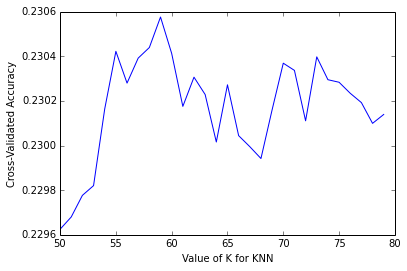

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

#Knn con randomized grid search para bajar el costo de compu

In [29]:
from sklearn.grid_search import RandomizedSearchCV
k_range = range(30, 81)
weight_options = ['uniform', 'distance']

In [30]:
# specify "parameter distributions" rather than a "parameter grid"
param_dist = dict(n_neighbors=k_range, weights=weight_options)

In [40]:
# rand = RandomizedSearchCV(knn, param_dist, cv=3, scoring='accuracy', n_iter=5, random_state=5)
# rand.fit(X_train_s, y_train_s)
# rand.grid_scores_

In [ ]:
# examine the best model
print rand.best_score_
print rand.best_params_

In [ ]:
plt.plot(k_range,rand.grid_scores_)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

#Clasificacion con arboles de decision

In [51]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train_s, y_train_s)

In [38]:
#con esto podemos predecir en vez de la clase, una probabilidad de clases(formato que necesitamos para la competencia)
# clf.predict_proba([[2., 2.]])

In [54]:
y_pred = clf.predict(X_test_s)
print metrics.accuracy_score(y_test_s, y_pred)

0.235063492967


In [61]:
X_test_s[1]
# X_test_s

array([-122.50705866,   37.77571229,   18.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    1.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    1.        ,    0.        ])

In [62]:
y_pred[1]

'ASSAULT'

In [63]:
clf.feature_importances_

array([ 0.22393097,  0.22539175,  0.2553809 ,  0.00060717,  0.00082968,
        0.00090366,  0.00095557,  0.00124112,  0.00109972,  0.00067303,
        0.00107256,  0.00041608,  0.00634664,  0.04246415,  0.04108638,
        0.03858902,  0.03616542,  0.04108577,  0.04036211,  0.0413983 ])

In [67]:
X_train_new.head()

,X,Y,Hour,BAYVIEW,CENTRAL,INGLESIDE,MISSION,NORTHERN,PARK,RICHMOND,SOUTHERN,TARAVAL,TENDERLOIN,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,-122.425892,37.774599,23,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
1,-122.425892,37.774599,23,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
2,-122.424363,37.800414,23,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
3,-122.426995,37.800873,23,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
4,-122.438738,37.771541,23,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
cross_val_score(clf, iris.data, iris.target, cv=10)